In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_pubmed import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.gat import StructuralOmegaGATCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logs_filename = 'logs/omega_function/pubmed/06-1-structural_gat_cossim_gamma_function.log'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=logs_filename
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

In [8]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [9]:
data = prepare_adjencency(data)

## Training

In [10]:
for run in range(30):
    for n_layers_gat in range(1, 4):
        omega = StructuralOmegaGATCosSim(
            device=device,
            dataset='pubmed',
            in_channels=data.x.shape[1],
            n_layers_gat=n_layers_gat,
            run=run,
            eval_steps=10,
            epochs=1000)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [11]:
n_layers_gat = 1

In [12]:
metrics = StructuralOmegaGATCosSim.read_metrics(
    dataset='pubmed',
    n_layers_gat=n_layers_gat)
print(metrics.shape)
metrics.head()

(3030, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.541099,0.526628,0.531828,0.523200,0.516758,0.523315
1,0,10,0.507327,0.483549,0.492782,0.656908,0.602938,0.645277
2,0,20,0.502706,0.477232,0.487017,0.697461,0.635945,0.678377
3,0,30,0.496771,0.472636,0.482282,0.717495,0.663339,0.691329
4,0,40,0.478878,0.463870,0.469865,0.724562,0.688799,0.684120


### Sumarize metrics per epoch

In [13]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [14]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [15]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.540879,0.001437,0.524943,0.001910,0.531712,0.001484,0.522155,0.007857,0.523584,0.009712,0.524969,0.008673
10,0.507250,0.000066,0.483538,0.000032,0.492737,0.000060,0.660569,0.004173,0.604446,0.006009,0.647188,0.004744
20,0.502423,0.000263,0.477121,0.000137,0.486845,0.000189,0.700579,0.004013,0.639713,0.006406,0.680995,0.004545
30,0.495125,0.001883,0.471704,0.001463,0.480846,0.001482,0.720324,0.005346,0.670533,0.008027,0.693097,0.007582
40,0.476452,0.003232,0.460686,0.002851,0.467491,0.002575,0.729102,0.005630,0.695295,0.008717,0.691465,0.007198


In [16]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
950,0.178673,0.004163,0.402099,0.021131,0.379392,0.027175,0.957625,0.004647,0.792648,0.015233,0.837810,0.021474
930,0.179875,0.003166,0.401555,0.020799,0.378385,0.026555,0.957030,0.004428,0.792257,0.014843,0.837752,0.020993
940,0.179752,0.004841,0.402418,0.020719,0.379074,0.026422,0.957208,0.004597,0.792180,0.014763,0.837561,0.020771
990,0.174752,0.003648,0.404381,0.021606,0.380415,0.026885,0.959308,0.004695,0.792175,0.015023,0.838036,0.020543
980,0.175653,0.003666,0.404109,0.021381,0.380178,0.026788,0.958914,0.004725,0.792075,0.014813,0.838022,0.020664


/tmp/ipykernel_1140325/4011872266.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1140325/4011872266.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1140325/4011872266.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future b

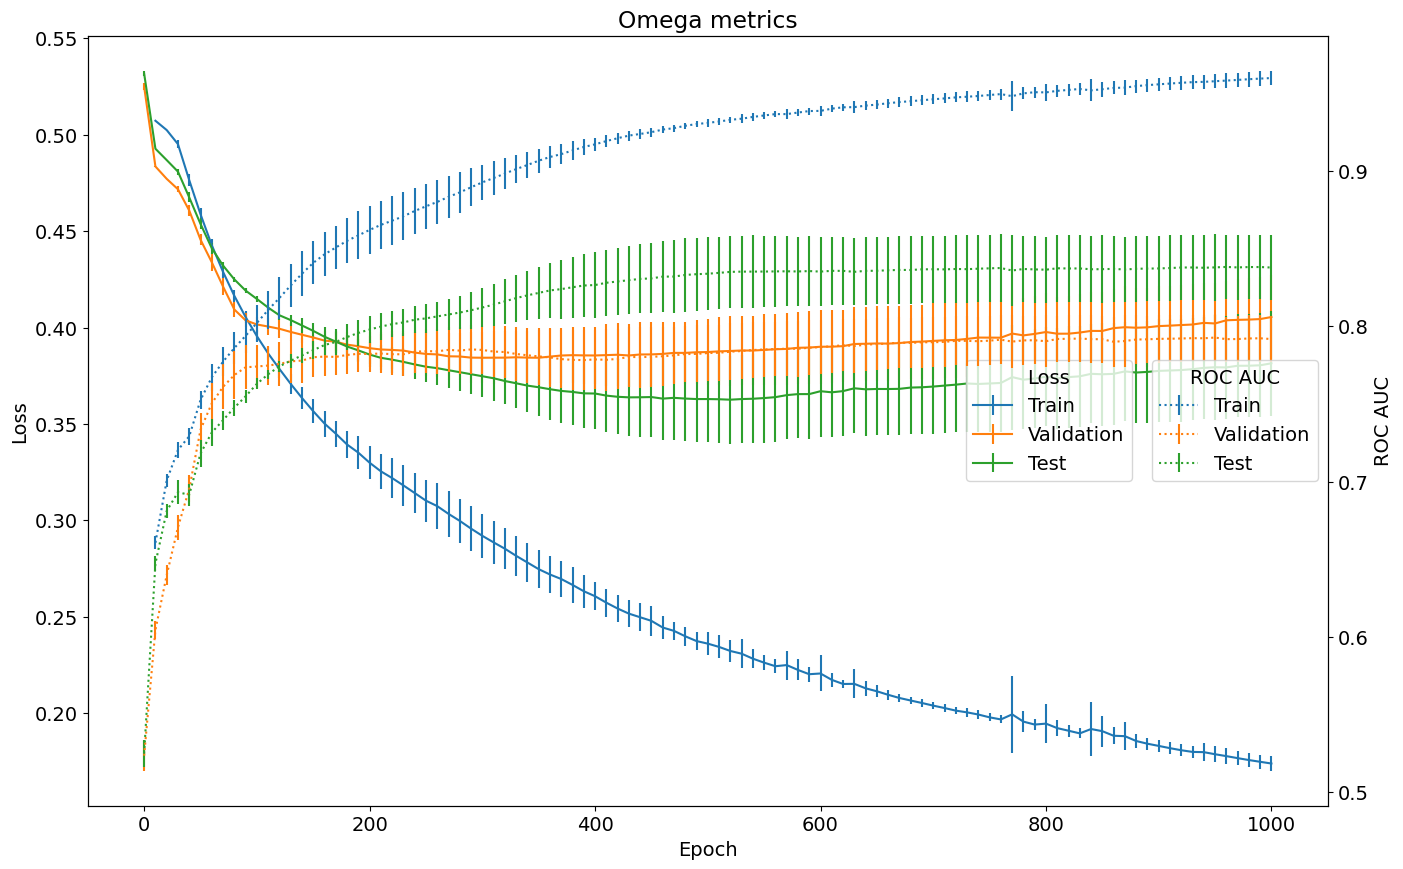

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/pubmed/structural_omega_gat_cossim_training_metrics_{n_layers_gat}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [18]:
n_layers_list = range(1, 4)

In [19]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_gat in n_layers_list:
    metrics = StructuralOmegaGATCosSim.read_metrics(dataset='pubmed', n_layers_gat=n_layers_gat)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_gat] = auc_val
    mean_loss_val_dict[n_layers_gat] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_gat] = auc_val
    std_loss_val_dict[n_layers_gat] = loss_val

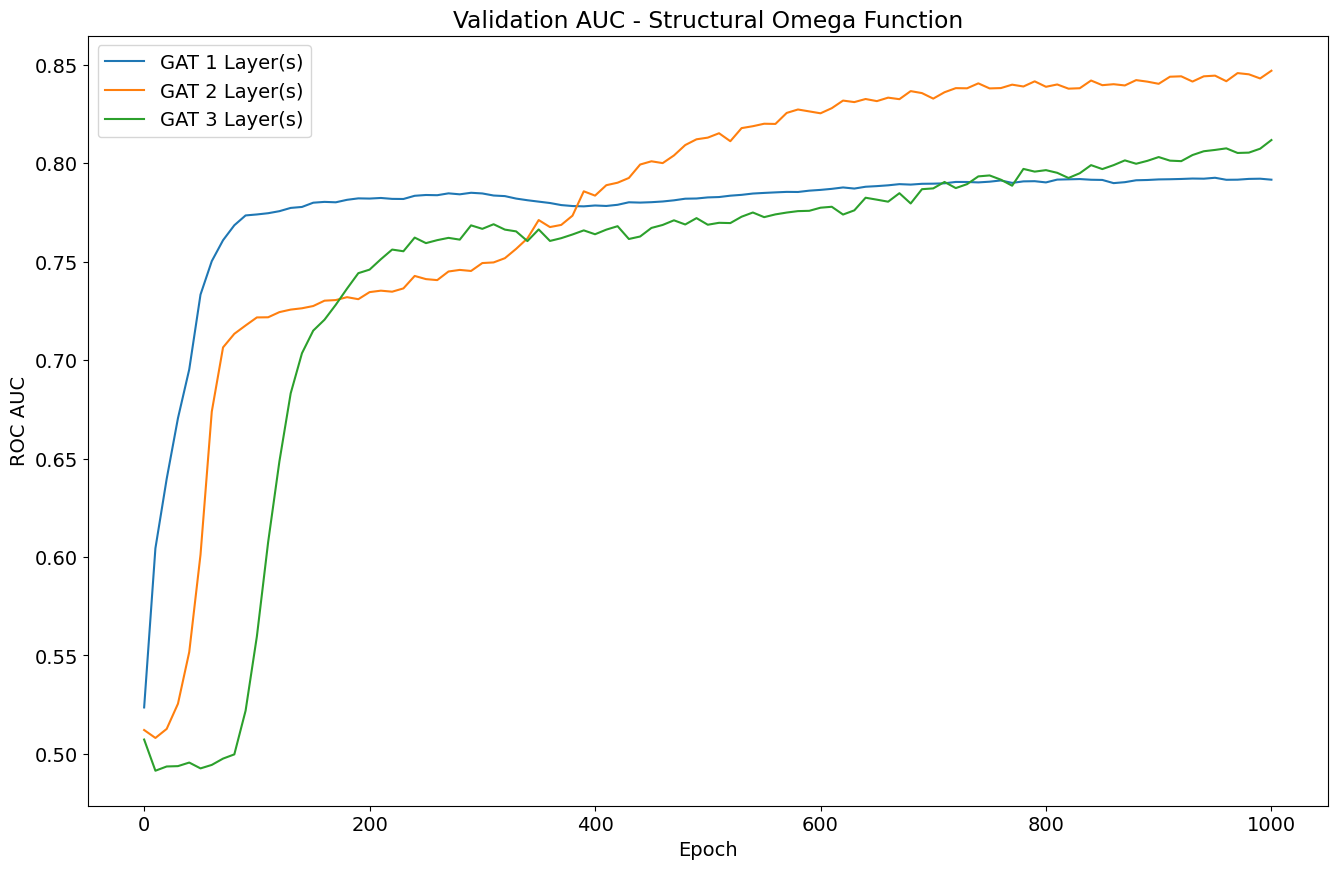

In [20]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    # ax1.errorbar(
    #     mean_auc_val_dict[n_layers].index,
    #     mean_auc_val_dict[n_layers],
    #     yerr=std_auc_val_dict[n_layers],
    #     ls='-',
    #     label=f'GAT {n_layers} Layer(s)')

    ax1.plot(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        # yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'GAT {n_layers} Layer(s)')

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [21]:
n_layers_list = range(1, 4)

In [22]:
full_metrics = []
for n_layers_gat in n_layers_list:
    metrics = StructuralOmegaGATCosSim.read_metrics(
        dataset='pubmed',
        n_layers_gat=n_layers_gat)
    metrics['n_layers_gat'] = n_layers_gat
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [23]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run              26.000000
epoch           760.000000
loss_train        0.129928
loss_val          0.334310
loss_test         0.382522
auc_train         0.969916
auc_val           0.888317
auc_test          0.860188
n_layers_gat      2.000000
Name: 2702, dtype: float64

In [24]:
best_model_metrics.to_json('models/structural_omega_gat_cossim/pubmed/best_model_info.json')